In [1]:
import geographiclib
import numpy as np
import vincenty
%matplotlib inline
import matplotlib.pyplot as plt
import time
import tikzplotlib
import scipy.integrate as integrate

In [2]:
a = 6378137.0
f = 1/298.257223563
b = a*(1-f)
a_sq = a**2
a_sq_plus_b_sq = (a ** 2) + (b ** 2)
a_sq_minus_b_sq = (a ** 2) - (b ** 2)

In [3]:
with open('GeodTest.dat') as fp:
    for line in fp:
        lat1, lon1, az1, lat2, lon2, az2, true_dist, arc_dist, reduced_len, area = [float(i) for i in line.strip().split()]
        break

In [4]:
class DistanceIntegrator:
    def __init__(self):
        self.lat1 = self.lat2 = self.lon1 = self.lon2 = 0
    
    def set_positions(self, p1, p2, unit='radians'):
        self.lat1, self.lon1 = p1
        self.lat2, self.lon2 = p2
        if unit != 'radians':
            self.lat1 = np.deg2rad(self.lat1)
            self.lon1 = np.deg2rad(self.lon1)
            self.lat2 = np.deg2rad(self.lat2)
            self.lon2 = np.deg2rad(self.lon2)
    def get_integration_sequence_cartesian(self, n):
        sequence = np.zeros((n,))
        d_lat = (self.lat2 - self.lat1) / (n-1)
        d_lon = (self.lon2 - self.lon1) / (n-1)
        prev_value = np.zeros((3,))
        current_value = np.zeros((3,))
        for i in range(n+1):
            current_lat = ((n-i)*self.lat1 + i*self.lat2) / (n)
            current_lon = ((n-i)*self.lon1 + i*self.lon2) / (n)
            current_value[0] = -a * np.cos(current_lat) * np.cos(current_lon)
            current_value[1] = -a * np.cos(current_lat) * np.sin(current_lon)
            current_value[2] = b * np.sin(current_lat)
            if i > 0:
                sequence[i-1] = np.sqrt(np.sum(np.power((current_value - prev_value), 2)))
            prev_value = current_value.copy()
        return sequence
    def get_integration_sequence_spherical(self, n):
        sequence = np.zeros((n,))
        for i in range(n):
            current_lat = ((n-1.5-i)*self.lat1 + (i+0.5)*self.lat2) / (n)
            first_term = np.power((a / (n)) *np.sin(current_lat)*(self.lon2 - self.lon1), 2)
            temp_a = (a / (n) * (self.lat2 - self.lat1)) ** 2
            temp_b = (b / (n) * (self.lat2 - self.lat1)) ** 2
            second_term = ( temp_a + temp_b - (temp_a - temp_b) * np.cos(2*current_lat))/2
            sequence[i] = np.sqrt(first_term + second_term)
        return sequence
    
    def find_haversine(self):
        dlon = self.lon2 - self.lon1 
        dlat = self.lat2 - self.lat1 
        temp = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(temp)) 
        r = 6371007.1809 # mean radius with equal area
        return c * r
    def find_vincenty(self):
        return vincenty.vincenty(np.rad2deg([self.lat1, self.lon1]), np.rad2deg([self.lat2, self.lon2]))

In [5]:
def integrate_simple(sequence):
    return np.sum(sequence)

def integrate_trapezoid(sequence):
    return np.sum(sequence[1:-1]) + (sequence[0] + sequence[-1]) / 2

In [6]:
di = DistanceIntegrator()
di.set_positions((lat1, lon1), (lat2, lon2), 'degrees')
true_dist = 9398502.0434687
test_cases = []
for i in range(19):
    test_cases.append(2**i + 1)
    test_cases.append(int(1.5*(2**i + 1)))
err_results = {
    'Cartesian Romberg': [],
    'Spherical Romberg': [],
    'Cartesian Trapezoid': [],
    'Spherical Trapezoid': [],
    'Cartesian Simple': [],
    'Spherical Simple': [],
    'Cartesian Simpson': [],
    'Spherical Simpson': []
}
time_results = {
    'Cartesian Romberg': [],
    'Spherical Romberg': [],
    'Cartesian Trapezoid': [],
    'Spherical Trapezoid': [],
    'Cartesian Simple': [],
    'Spherical Simple': [],
    'Cartesian Simpson': [],
    'Spherical Simpson': []
}

sequence_times = {
    'Cartesian': [],
    'Spherical': []
}

old_time = time.time()
err_results['Haversine'] = np.abs(di.find_haversine() - true_dist)
time_results['Haversine'] = time.time() - old_time

for t in test_cases:

    old_time = time.time()
    cartesian_sequence = di.get_integration_sequence_cartesian(t)
    sequence_times['Cartesian'].append(time.time() - old_time)
    
    old_time = time.time()
    err_results['Cartesian Simple'].append(np.abs(integrate_simple(cartesian_sequence) - true_dist))
    time_results['Cartesian Simple'].append(time.time() - old_time)
    
    old_time = time.time()
    err_results['Cartesian Trapezoid'].append(np.abs(integrate_trapezoid(cartesian_sequence) - true_dist))
    time_results['Cartesian Trapezoid'].append(time.time() - old_time)
    
    if np.log2(t - 1) % 1 == 0:
        old_time = time.time()
        err_results['Cartesian Romberg'].append(np.abs(integrate.romb(cartesian_sequence) - true_dist))
        time_results['Cartesian Romberg'].append(time.time() - old_time)
    
    old_time = time.time()
    err_results['Cartesian Simpson'].append(np.abs(integrate.simps(cartesian_sequence) - true_dist))
    time_results['Cartesian Simpson'].append(time.time() - old_time)
    
    old_time = time.time()
    spherical_sequence = di.get_integration_sequence_spherical(t)
    sequence_times['Spherical'].append(time.time() - old_time)
    
    old_time = time.time()
    err_results['Spherical Simple'].append(np.abs(integrate_simple(spherical_sequence) - true_dist))
    time_results['Spherical Simple'].append(time.time() - old_time)
    
    old_time = time.time()
    err_results['Spherical Trapezoid'].append(np.abs(integrate_trapezoid(spherical_sequence) - true_dist))
    time_results['Spherical Trapezoid'].append(time.time() - old_time)
    
    if np.log2(t - 1) % 1 == 0:
        old_time = time.time()
        err_results['Spherical Romberg'].append(np.abs(integrate.romb(spherical_sequence) - true_dist))
        time_results['Spherical Romberg'].append(time.time() - old_time)
    
    old_time = time.time()
    err_results['Spherical Simpson'].append(np.abs(integrate.simps(spherical_sequence) - true_dist))
    time_results['Spherical Simpson'].append(time.time() - old_time)

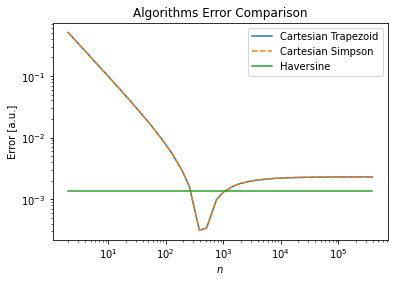

In [7]:
shows = ['Cartesian Trapezoid', 'Cartesian Simpson']
for r in shows:
    array_to_show = np.array(err_results[r]) / true_dist
    show_cases = test_cases
    if 'Romb' in r:
        romb_filter = np.log2(np.array(test_cases) - 1) % 1 == 0
        show_cases = np.array(show_cases)[romb_filter]
    plt.loglog(show_cases, array_to_show, linestyle='-' if 'Trap' in r else '--')
plt.loglog(test_cases, [err_results['Haversine']  / true_dist for i in range(len(test_cases))])
plt.legend(shows + ['Haversine'])
plt.xlabel('$n$')
plt.ylabel('Error [a.u.]')
plt.title('Algorithms Error Comparison')
tikzplotlib.save("algo_1.tex")

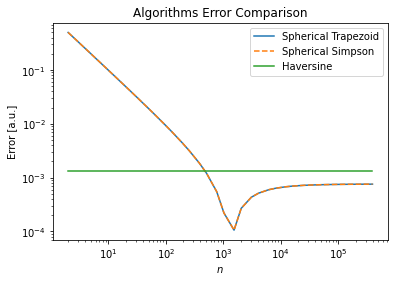

In [8]:
shows = ['Spherical Trapezoid', 'Spherical Simpson']
for r in shows:
    array_to_show = np.array(err_results[r]) / true_dist
    show_cases = test_cases
    if 'Romb' in r:
        romb_filter = np.log2(np.array(test_cases) - 1) % 1 == 0
        show_cases = np.array(show_cases)[romb_filter]
    plt.loglog(show_cases, array_to_show, linestyle='-' if 'Trap' in r else '--')
plt.loglog(test_cases, [err_results['Haversine']  / true_dist for i in range(len(test_cases))])
plt.legend(shows + ['Haversine'])
plt.xlabel('$n$')
plt.ylabel('Error [a.u.]')
plt.title('Algorithms Error Comparison')
tikzplotlib.save("algo_2.tex")

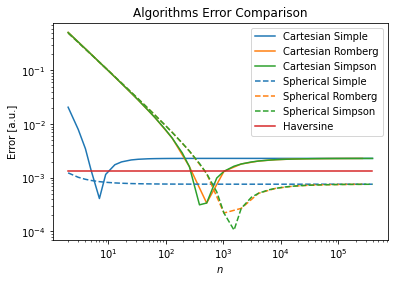

In [9]:
shows = ['Cartesian Simple', 'Cartesian Romberg', 'Cartesian Simpson' , 'Spherical Simple', 'Spherical Romberg', 'Spherical Simpson']
colors = ['C0', 'C1', 'C2', 'C0', 'C1', 'C2', 'C3']
styles = ['-', '-', '-', '--', '--', '--']
j = 0
for r in shows:
    
    array_to_show = np.array(err_results[r]) / true_dist
    show_cases = test_cases
    if 'Romb' in r:
        romb_filter = np.log2(np.array(test_cases) - 1) % 1 == 0
        show_cases = np.array(show_cases)[romb_filter]
    plt.loglog(show_cases, array_to_show, color=colors[j], linestyle=styles[j])
    j += 1
plt.loglog(test_cases, [err_results['Haversine']  / true_dist for i in range(len(test_cases))], color=colors[j])

plt.legend(shows + ['Haversine'])
plt.xlabel('$n$')
plt.ylabel('Error [a.u.]')
plt.title('Algorithms Error Comparison')
tikzplotlib.save("algo_3.tex")

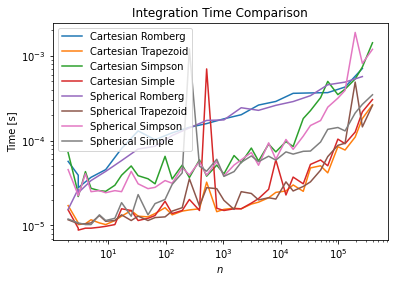

In [10]:
shows = ['Cartesian Romberg', 'Cartesian Trapezoid','Cartesian Simpson', 'Cartesian Simple', 'Spherical Romberg', 'Spherical Trapezoid', 'Spherical Simpson', 'Spherical Simple']
for r in shows:
    array_to_add = np.array(sequence_times[r.split(' ')[0]])
    show_cases = test_cases
    if 'Romb' in r:
        romb_filter = np.log2(np.array(test_cases) - 1) % 1 == 0
        array_to_add = array_to_add[romb_filter]
        show_cases = np.array(show_cases)[romb_filter]
    plt.loglog(show_cases, np.array(time_results[r]))
plt.legend(shows)
plt.xlabel('$n$')
plt.ylabel('Time [s]')
plt.title('Integration Time Comparison')
tikzplotlib.save("inttime.tex")

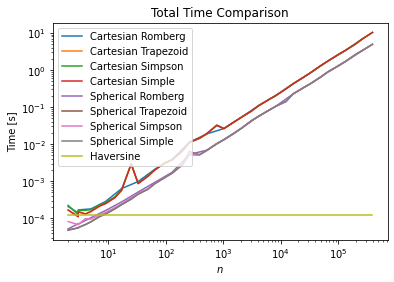

In [11]:
shows = ['Cartesian Romberg', 'Cartesian Trapezoid','Cartesian Simpson', 'Cartesian Simple', 'Spherical Romberg', 'Spherical Trapezoid', 'Spherical Simpson', 'Spherical Simple']
for r in shows:
    array_to_add = np.array(sequence_times[r.split(' ')[0]])
    show_cases = test_cases
    if 'Romb' in r:
        romb_filter = np.log2(np.array(test_cases) - 1) % 1 == 0
        array_to_add = array_to_add[romb_filter]
        show_cases = np.array(show_cases)[romb_filter]
    plt.loglog(show_cases, np.array(time_results[r]) + array_to_add)
plt.loglog(test_cases, [time_results['Haversine'] for i in range(len(test_cases))])
plt.legend(shows + ['Haversine'])
plt.xlabel('$n$')
plt.ylabel('Time [s]')
plt.title('Total Time Comparison')
tikzplotlib.save("totaltime.tex")